# Beispiel Regler- und Folgebeobachter

**(6. Übung Flachheitsbasierte Folgeregelung, Aufgabe 2)**

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/flavert-nbviewer-content

**Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!**

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

In [1]:
import numpy as np
import scipy.integrate as sci
import scipy.special as scs
import matplotlib.pyplot as plt
import abc
from typing import Union, Dict
#%matplotlib widget

## Trajektoriengenerator

(wäre eigentlich irgendwo als Modul hinterlegt, hier einfach reinkopiert aus Übung 2)

In [2]:
class TrajGenBase(abc.ABC):

    def __init__(self, t_start: float, t_end: float, y_start: float, y_end: float, smooth_to: int):
        self._t0 = t_start
        self._t1 = t_end
        self._y0 = y_start
        self._y1 = y_end
        self._gamma = smooth_to
        self._y0_vec = np.zeros((smooth_to + 1, 1))
        self._y0_vec[0, 0] = y_start
        self._y1_vec = np.zeros((smooth_to + 1, 1))
        self._y1_vec[0, 0] = y_end

    def __call__(self, t: Union[float, np.ndarray[float], list[float]], max_deriv: int = -1) -> np.ndarray[float]:
        if isinstance(t, (np.ndarray, list)):
            return self.eval_v(t)
        else:
            return self.eval(t)

    @abc.abstractmethod
    def eval(self, t: float, max_deriv=-1) -> np.ndarray[float]:
        ...

    @abc.abstractmethod
    def eval_v(self, t: np.ndarray[float], max_deriv=-1) -> np.ndarray[float]:
        ...


class TrajGenProto(TrajGenBase):

    def __init__(self, t_start: float, t_end: float, y_start: float, y_end: float, smooth_to: int):
        super().__init__(t_start, t_end, y_start, y_end, smooth_to)

        self._delta_t = t_end - t_start
        self._t_deriv_scaling = np.ones((smooth_to + 1, 1))
        for i in range(1, self._gamma + 1, 1):
            self._t_deriv_scaling[i] = self._t_deriv_scaling[i-1] / self._delta_t

        self._c = self.setup_coeffs(y_start, y_end, smooth_to)

    @staticmethod
    def setup_coeffs(y0: float, y1: float, gamma: int) -> np.ndarray[float]:
        alpha = scs.factorial(2 * gamma + 1)
        alpha_gamma = alpha / (scs.factorial(gamma)**2)
        delta_y = y1 - y0

        coeffs = np.zeros(2 * gamma + 2)
        coeffs[0] = y0
        for k in range(0, gamma + 1):
            coeffs[gamma + 1 + k] = delta_y * alpha_gamma * scs.binom(gamma, k) * (-1)**k / (gamma + k + 1)

        return coeffs

    @staticmethod
    def horner(c: np.ndarray[float], x: Union[float, np.ndarray[float]], gamma: int) -> np.ndarray[float]:
        y = np.zeros((gamma+1, x.size))
        for i in range(c.size-1, -1, -1):
            for j in range(gamma, 0, -1):
                y[j] = y[j] * x + j * y[j-1]
            y[0] = c[i] + y[0] * x

        return y

    def eval(self, t: float, max_deriv: int = -1) -> np.ndarray[float]:
        maxderiv = self._gamma if (max_deriv < 0) or (max_deriv > self._gamma) else max_deriv
        if t < self._t0:
            return self._y0_vec[0:maxderiv+1, 0]
        elif t > self._t1:
            return self._y1_vec[0:maxderiv+1, 0]
        else:
            return (self.horner(self._c, (t - self._t0) / self._delta_t, maxderiv) * self._t_deriv_scaling)[:, 0]

    def eval_v(self, t: np.ndarray[float], max_deriv: int = -1) -> np.ndarray[float]:
        maxderiv = self._gamma if (max_deriv < 0) or (max_deriv > self._gamma) else max_deriv
        y_mat = np.zeros((maxderiv + 1, t.size))
        y_mat[:, t < self._t0] = self._y0_vec[0:maxderiv+1]
        y_mat[:, t > self._t1] = self._y1_vec[0:maxderiv+1]
        inds_for_polys = (t >= self._t0) & (t <= self._t1)
        t_for_polys = (t[inds_for_polys] - self._t0) / self._delta_t
        y_mat[:, inds_for_polys] = self.horner(self._c, t_for_polys, maxderiv) * self._t_deriv_scaling

        return y_mat

## Simulationsparameter

In [3]:
# Start- und Endzeit Simulation
tsim_start = 0.0
tsim_end = 5.0
dt = 0.01

# Anfangswerte System und Beobachter
x10 = 1.5
x20 = 0.0
xHat10 = 0.5
xHat20 = 0.0

# Eigenwerte Regler
kappa0 = -2.0
kappa1 = -2.0

# Eigenwerte Beobachter
lambda0 = -5.0
lambda1 = -5.0

# Parameter Solltrajektorie
t0 = 2
t1 = 4
y1 = 1
y2 = 5

# sich ergebende Parameter für Regler und Beobachter
sim_para = dict()
sim_para["k0"] = kappa0 * kappa1
sim_para["k1"] = -(kappa0 + kappa1)
sim_para["lambda0"] = lambda0
sim_para["lambda1"] = lambda1

# Solltrajektoriengenerator
traj_gen = TrajGenProto(t0, t1, y1, y2, 2)

## Rechte Seite der System- und Beobachterdifferenzialgleichung

In [4]:
def system(t: float, x: np.ndarray[float], tg: TrajGenProto, para: Dict) -> np.ndarray[float]:
    x1 = x[0]
    x2 = x[1]
    x1Hat = x[2]
    x2Hat = x[3]

    yref = tg(t)

    # Regler
    u = -x2**2 + yref[2] - para["k1"] * (x2Hat - yref[1]) - para["k0"] * (x1Hat - yref[0])

    # Beobachter
    l1 = 2 * yref[1] - para["lambda0"] - para["lambda1"]
    l2 = para["lambda0"] * para["lambda1"] - 2 * (para["lambda0"] + para["lambda1"]) * yref[1] + 4 * yref[1]**2 - 2 * yref[2]

    x1HatDot = x2Hat + l1 * (x1 - x1Hat)
    x2HatDot = x2Hat**2 + u + l2 * (x1 - x1Hat)

    x1Dot = x2
    x2Dot = x2**2 + u
    x3Dot = x1HatDot
    x4Dot = x2HatDot

    return np.array([x1Dot, x2Dot, x3Dot, x4Dot])

Definition eines Stop-Events, damit Simulation geordnet abbricht, falls etwas nicht richtig konvergiert
([Doku hier...](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html))

In [5]:
def stop_event(t: float, y: float) -> float:
    return y[0]**2 + y[2]**2 - 100


stop_event.terminal = True
stop_event.direction = 1

## Numerische Simulation

In [6]:
t_vals = np.arange(tsim_start, tsim_end+dt, dt)
sol = sci.solve_ivp(lambda t, x: system(t, x, traj_gen, sim_para), t_span=[tsim_start, tsim_end], 
                    y0=[x10, x20, xHat10, xHat20], t_eval=t_vals, events=stop_event)

## Grafische Darstellung

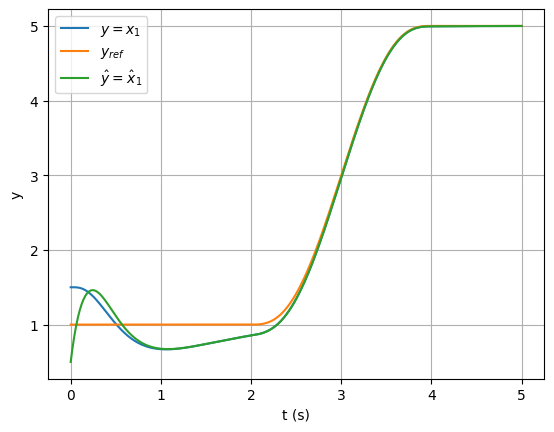

In [7]:
if sol.t_events[0].size > 0:
    print("==> Regler oder Beobachter konvergieren nicht! <==")

yref = traj_gen(t_vals)
plt.figure()
plt.plot(sol.t, sol.y[0,:], label="$y = x_1$")
plt.plot(t_vals, yref[0,:], label="$y_{ref}$")
plt.plot(sol.t, sol.y[2,:], label="$\\hat y = \\hat x_1$")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("y")
plt.grid()
# plt.savefig("nlbeob-regler.pdf", dpi=300)